In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Download and extract images

In [2]:
data_url = "https://github.com/thetestspecimen/notebooks/raw/main/datasets/rock_paper_scissors/rock_paper_scissors.zip"
root_folder = "rps"
http_response = urlopen(data_url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall(path=f"./{root_folder}")

# Check data

In [3]:
for root, dirs, files in os.walk(root_folder):
    print(f"{len(dirs)} directories and {len(files)} files in '{root}'")

3 directories and 0 files in 'rps'
0 directories and 200 files in 'rps/rock'
0 directories and 200 files in 'rps/scissors'
0 directories and 200 files in 'rps/paper'


# Plot an example from each class

In [4]:
# View an image
import matplotlib.image as mpimg
import random

def plot_example_image(target_class):
  
  # target directory
  target_folder = f'rps/{target_class}'

  # random image
  random_image = random.sample(os.listdir(target_folder), 1)

  # plot image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(f"Class: {target_class}")
  plt.axis("off")

  print(f"Type: {type(img)}")
  print(f"Shape: {img.shape}")
  print(f"Colour channels: {img.shape[2]}")
  print(f"Size: {img.size / 1000}KB")
  print(f"Max value: {img.max()}")
  print(f"Min value: {img.min()}")
  print(f"Image name: {random_image[0]}")

  return img

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.8901960849761963
Min value: 0.003921568859368563
Image name: BTcHjuerLAYWzx8S.png


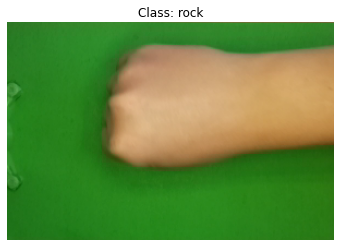

In [5]:
img = plot_example_image("rock"); 

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.8549019694328308
Min value: 0.0
Image name: 73UfZ8Dwj0OB66IV.png


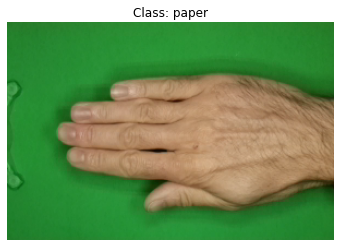

In [6]:
img = plot_example_image("paper"); 

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.9411764740943909
Min value: 0.0
Image name: e7wuzMq70FDcvaFr.png


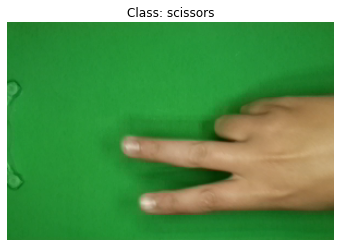

In [7]:
img = plot_example_image("scissors"); 

# Prepare data

In [8]:
# Constants

IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
BATCH_SIZE = 32
DATA_DIR = f"{root_folder}/"
SEED = 12

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR, 
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMAGE_SIZE,
                                                           shuffle=True, 
                                                           seed=SEED,
                                                           validation_split=0.2,
                                                           subset='training')                          

Found 600 files belonging to 3 classes.
Using 480 files for training.


In [10]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR, 
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMAGE_SIZE,
                                                           shuffle=True, 
                                                           seed=SEED,
                                                           validation_split=0.2,
                                                           subset='validation')    

Found 600 files belonging to 3 classes.
Using 120 files for validation.


In [11]:
class_names = train_data.class_names
class_names

['paper', 'rock', 'scissors']

# Plot Example data from all classes

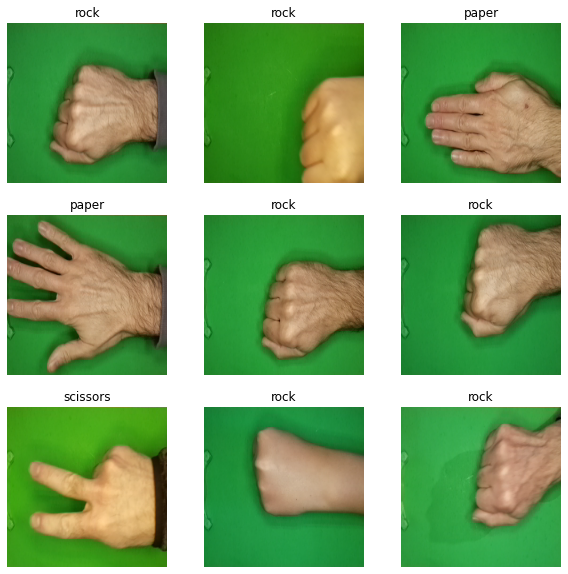

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.math.argmax(labels[i])])
    plt.axis("off")

# Data augmentation

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [14]:
# the image files are PNG, and therefore already sit beween 0 and 1.
# However, if they were jpg you would need the Rescaling layer below.

data_augmentation = Sequential([
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomZoom(0.2),
                                # preprocessing.Rescaling(1./255.),
], name='data_augmentation')

# Configure Datasets

In [15]:
train_data, val_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

In [16]:
train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
train_data, val_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

# Create Model

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, Flatten

num_classes = len(class_names)

hidden_layers = Sequential([
                            Conv2D(filters=32,kernel_size=(3,3), padding='same', kernel_initializer='glorot_uniform', activation='selu'),
                            MaxPool2D(pool_size=(2,2)),
                            Conv2D(filters=64,kernel_size=(3,3), padding='same', kernel_initializer='glorot_uniform', activation='selu'),
                            MaxPool2D(pool_size=(2,2)),
                            Conv2D(filters=64,kernel_size=(3,3), padding='same', kernel_initializer='glorot_uniform', activation='selu'),
                            MaxPool2D(pool_size=(2,2)),
                            GlobalAveragePooling2D(keepdims=True),
                            Flatten(), # this is just for consistency with Julia (Flux), as you could just set "keepdims=False" in the layer above instead. 
                            Dense(64, kernel_initializer='glorot_uniform', activation='selu'),
], name='convolutional_network')

In [19]:
inputs = layers.Input(shape=(IMAGE_SIZE + (3,)), name='input_layer')
x = data_augmentation(inputs)
x = hidden_layers(x)
outputs = Dense(units=num_classes, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs,outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 160, 160, 3)      0         
 al)                                                             
                                                                 
 convolutional_network (Sequ  (None, 64)               60480     
 ential)                                                         
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 60,675
Trainable params: 60,675
Non-trainable params: 0
_________________________________________________________________


# Compile and Fit Model

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_data,
                    epochs=20,
                    validation_data=val_data)

Epoch 1/20
15/15 [==============================] - 10s 176ms/step - loss: 4.5578 - accuracy: 0.3417 - val_loss: 1.3896 - val_accuracy: 0.3833
Epoch 2/20
15/15 [==============================] - 1s 92ms/step - loss: 1.3225 - accuracy: 0.4375 - val_loss: 1.1585 - val_accuracy: 0.3917
Epoch 3/20
15/15 [==============================] - 1s 82ms/step - loss: 1.2601 - accuracy: 0.4062 - val_loss: 1.5836 - val_accuracy: 0.3167
Epoch 4/20
15/15 [==============================] - 1s 59ms/step - loss: 1.1784 - accuracy: 0.4354 - val_loss: 0.9151 - val_accuracy: 0.6667
Epoch 5/20
15/15 [==============================] - 1s 45ms/step - loss: 0.9956 - accuracy: 0.4792 - val_loss: 1.0189 - val_accuracy: 0.4250
Epoch 6/20
15/15 [==============================] - 1s 46ms/step - loss: 1.0268 - accuracy: 0.4854 - val_loss: 0.9296 - val_accuracy: 0.5583
Epoch 7/20
15/15 [==============================] - 1s 45ms/step - loss: 0.9425 - accuracy: 0.5167 - val_loss: 1.1386 - val_accuracy: 0.4500
Epoch 8/20
